# wordle

Make wordle, the fun viral word game sensation, no longer fun.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
from copy import deepcopy

In [5]:
#turns out the first major challenge is assembling a good dictionary. 
#to do this, we are going to use a composite of two sources.
# First, we will be using norvig's ngram frequency counts that is based on
# google's 1 trillion word corpus. 
# We will then reject any non-english words using a dictionary

i = 0
words_google = []
freq_google = []
with open("dictionaries/count_1w.txt") as wordfile:
    for line in wordfile:
        line_data = line.strip().split("\t")
        if(len(line_data[0])==5):
            words_google.append(line_data[0])
            freq_google.append(line_data[1])
words_google = np.array(words_google)
freq_google = np.array(freq_google).astype(int)
            
# words_alpha taken from: https://github.com/dwyl/english-words
with open('dictionaries/words_alpha.txt') as word_file:
    words_alpha = set(word_file.read().split())
words_alpha = [w for w in words_alpha if len(w)==5]

print("Length of google words dataset:",len(words_google))
print("Length of dictionary dataset",len(words_alpha))

Length of google words dataset: 39933
Length of dictionary dataset 15918


In [6]:
filt = np.isin(words_google, words_alpha)
words_filt = words_google[filt]
freq_filt = freq_google[filt]
print("Length of filtered dataset",len(words_filt))

Length of filtered dataset 9383


In [7]:
#sgb-words taken from norvig
with open('dictionaries/sgb-words.txt') as word_file:
    words = list(set(word_file.read().split()))
words=np.array(words)

In [8]:
# slightly trim down this word set by only keeping the ones that are relatively frequent according to google.

w_freq = []
for w in words:
    res = freq_google[words_google==w]
    if(len(res)>0):
        w_freq.append(res[0])
    else:
        w_freq.append(0)
w_freq = np.array(w_freq)

In [9]:
print("Length before filtering:", len(words))
words = words[w_freq!=0]
words = words[np.isin(words, words_alpha)]
print("Length after filtering:", len(words))

Length before filtering: 5757
Length after filtering: 5086


In [10]:
# a nice fallback/starter dictionary
# taken from https://github.com/first20hours/google-10000-english
# with open("dictionaries/google-10000-english-usa-no-swears-medium.txt") as word_file:
#     words = set(word_file.read().split())
# print(len(words))
# words_5 = [w for w in words if len(w)==5]
# print(len(words_5))
# words = words_5

In [89]:
#there are likely far faster numeric representations of this information, but I find 
#this to be intuitive.
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
possible_letters = [list(alphabet), #cant just do [alphabet]*5 as it creates a reference to a single list 
                    list(alphabet), 
                    list(alphabet), 
                    list(alphabet), 
                    list(alphabet)] 
required_letters = []

In [12]:
def get_possible_letters(possible_letters, guess, true_word):
    #replace this function with a "get hint from true word" and a "get possible letters from hint"
    # combo
    pl = deepcopy(possible_letters)
    required_letters = []
    for i_g, l in enumerate(guess):
        if l not in true_word:
            #remove from each index
            for i in range(len(pl)):
                try:
                    pl[i].remove(l)
                except ValueError:
                    pass
        else: #the letter is in the word
            if l == true_word[i_g]:
                #it is in the correct location
                pl[i_g] = [l]
            else:
                #it was not in the correct location
                #remove the letter from the other lists and add it to the required letters list
                try:
                    pl[i_g].remove(l)
                except ValueError:
                    pass
                required_letters.append(l)
    
                
    return pl, required_letters

%timeit get_possible_letters(possible_letters, "chief", "proxy")

101 µs ± 2.93 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [144]:
def get_words_subset(words, possible_letters, required_letters):
    #structure this code to exit as early as possible for fastest running
    words_subset = []
    for r in required_letters:
        for w in words:
            if r in w:
                possible=True
                for l, pl in zip(w, possible_letters):
                    if l not in pl:
                        possible=False
                        break
                if possible:
                    words_subset.append(w)
    return words_subset

%timeit words_subset = get_words_subset(words, possible_letters, required_letters)

4 ms ± 36 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [151]:
def get_words_subset(words, possible_letters, required_letters):
    words_subset = []
    for w in words:
        possible_word = True
        for l, a in zip(w, possible_letters):
            if l not in a:
                possible_word = False
                break
        for l in required_letters:
            if l not in w:
                possible_word = False
                break
        if possible_word:
            words_subset.append(w)
    return words_subset

%timeit get_words_subset(words, possible_letters, required_letters)

4.73 ms ± 175 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [145]:
possible_letters, required_letters = get_possible_letters(possible_letters, "rates", "proxy")
words_subset = get_words_subset(words, possible_letters, required_letters)

In [146]:
print(len(words_subset))

142


In [202]:
def get_guess_scores(words_subset, possible_letters, required_letters, guess_subset=None):
    if guess_subset is None:
        guess_subset = words_subset
    guess_scores = []
    for w_guess in guess_subset:
        pool = []
        for w_test_true in words_subset:
            pl, r = get_possible_letters(possible_letters, w_guess, w_test_true)
            w_sub = get_words_subset(words_subset, pl, r)
            pool.append(len(w_sub))
        guess_scores.append([w_guess, np.mean(pool)])
    guess_scores = np.array(guess_scores)
    return guess_scores

# %timeit get_guess_scores(words_subset, possible_letters, required_letters)

In [269]:
#calculate the best initial guess. This takes a while but only needs to be done once.
#takes about 40 minutes
# a faster way to calculate the initial guess using multigrid inspired methods is presented below

# possible_letters = [list(alphabet), #cant just do [alphabet]*5 as it creates a reference to a single list 
#                     list(alphabet), 
#                     list(alphabet), 
#                     list(alphabet), 
#                     list(alphabet)] 
# required_letters = []
# guess_scores=get_guess_scores(words_small, possible_letters, required_letters)
# guess_scores = guess_scores[guess_scores[:,1].astype(float).argsort()] # sort them so we can take a look
# print(guess_scores)
# pickle.dump( guess_score, open( "initial_guess_score.pkl", "wb" ) )

In [252]:
words_small = words#[:300]

In [267]:
%%time
# do a faster guess score calculation. This is particularly important when the word list is long
# 1. randomly sample some possible true words from your word list.
# 2. Calculate this guess score on the sampled list. 
# 3. Take the top 20 guesses and calculate a more accurate guess score using the full word list.
possible_letters = [list(alphabet), #cant just do [alphabet]*5 as it creates a reference to a single list 
                    list(alphabet), 
                    list(alphabet), 
                    list(alphabet), 
                    list(alphabet)] 
required_letters = []
test_words=words[np.random.choice(len(words_small), size=10, replace=False)] # there's probably a better way to do this
guess_scores = get_guess_scores(test_words, possible_letters, required_letters, guess_subset=words_small)
guess_scores = guess_scores[guess_scores[:,1].astype(float).argsort()] # sort them so we can take a look

best_guesses = guess_scores[:1000, 0]
print(best_guesses[:10])
test_words=words[np.random.choice(len(words_small), size=100, replace=False)] # there's probably a better way to do this
guess_scores = get_guess_scores(test_words, possible_letters, required_letters, guess_subset=best_guesses)
guess_scores = guess_scores[guess_scores[:,1].astype(float).argsort()] # sort them so we can take a look

best_guesses = guess_scores[:100, 0]
print(best_guesses[:10])
test_words=words[np.random.choice(len(words_small), size=300, replace=False)] # there's probably a better way to do this
guess_scores = get_guess_scores(test_words, possible_letters, required_letters, guess_subset=best_guesses)
guess_scores = guess_scores[guess_scores[:,1].astype(float).argsort()] # sort them so we can take a look

best_guesses = guess_scores[:10, 0]
guess_scores = get_guess_scores(words_small, possible_letters, required_letters, guess_subset=best_guesses)
guess_scores = guess_scores[guess_scores[:,1].astype(float).argsort()] # sort them so we can take a look
print(guess_scores[:10])

['deems' 'prise' 'upper' 'saber' 'podia' 'aegis' 'syrup' 'grips' 'poser'
 'pines']
['aloes' 'mates' 'rates' 'tames' 'tares' 'pates' 'rites' 'aides' 'hates'
 'reals']
[['tares' '6.773333333333333']
 ['rates' '6.78']
 ['nares' '7.173333333333333']
 ['reals' '7.213333333333333']
 ['aloes' '7.58']
 ['tears' '7.68']
 ['earls' '7.846666666666667']
 ['cares' '7.94']
 ['tires' '8.093333333333334']
 ['rites' '8.146666666666667']]
CPU times: user 52.7 s, sys: 20 ms, total: 52.7 s
Wall time: 52.7 s


In [270]:
# I've seen adieu mentioned on some articles. It performs relatively poorly with a mean pool size of 261
guess_scores = get_guess_scores(words_small, possible_letters, required_letters, guess_subset=["adieu"])

In [ ]:
# Given a guess, some restrictions and a word subset
# return a list of how many attempts it would take to complete for every word in the set if it was the true one
#
# The idea behind this is that we might be able to avoid issues with trying to guess a single 
# consonant as your last word
#
# for each word in the word subset:
#     calculate the resulting subset using that word as a guess
#         if len subset == 1
#             we have found the true word.
#         else, recurse.
# 

def get_guess_scores_mean_to_completion(words_subset, possible_letters, required_letters):
    # This is a different way of calculating what the best guess to use is. 
    # instead of just looking at the resulting size of the pool, choose the guess that will minimize 
    # the average number of guesses to get the correct answer.
    guess_scores = []
    for w_guess in words_subset:
        pool = []
        for w_test_true in words_subset:
            pl, r = get_possible_letters(possible_letters, w_guess, w_test_true)
            w_sub = get_words_subset(words_subset, pl, r)
            pool.append(len(w_sub))
        guess_scores.append([w_guess, np.mean(pool)])
    guess_scores = np.array(guess_scores)
    return guess_scores

In [148]:
# in order to integrate with the web app we need to write code that 
# returns the possible letters and required letters without knowing the true word
# The information that is returned is the location of true letters, the location of possible letters
# and letters that are incorrect.

def get_possible_letters_from_hint(possible_letters, guess, hint):
    #the hint is formatted as:
    #  n: this letter is not in the word
    #  y: this letter is in the word, and is in the right place
    #  m: this letter is in the word, but is not in the right place
    pl = deepcopy(possible_letters)
    required_letters = []
    for i_g, l in enumerate(guess):
        if hint[i_g] == 'n':
            #remove from each index
            for i in range(len(pl)):
                try:
                    pl[i].remove(l)
                except ValueError:
                    pass
        elif hint[i_g] == 'y': #the letter is in the word
            #it is in the correct location
            pl[i_g] = [l]
        else:
            #it was not in the correct location
            #remove the letter from the other lists and add it to the required letters list
            try:
                pl[i_g].remove(l)
            except ValueError:
                pass
            required_letters.append(l)            
    return pl, required_letters

%timeit get_possible_letters_from_hint(possible_letters, "rates", "nnnny")

106 µs ± 5.64 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [262]:
possible_letters = [list(alphabet), #cant just do [alphabet]*5 as it creates a reference to a single list 
                    list(alphabet), 
                    list(alphabet), 
                    list(alphabet), 
                    list(alphabet)] 
required_letters = []
hint='nnnnn'
words_subset = words
guess_data = []
attempts = 1

guess_scores=pickle.load(open("initial_guess_scores.pkl", "rb" )) # precomputed best guess 
guess_scores = guess_scores[guess_scores[:,1].astype(float).argsort()]

print("Best initial guess is: rates")

while not hint == 'yyyyy':
    #loop, providing new optimal guesses until we have sucessfully found the word
    guess = input("Enter your guess: ")

    try:
        my_guess_score = guess_scores[guess_scores[:, 0]==guess][0, 1]
    except:
        my_guess_score=0
    guess_data.append([attempts, guess, f"{float(my_guess_score):.2f}", len(words_subset)])
    print(guess_data[-1]) 
   
    hint = input("input the hint received: ")
    
    possible_letters, r = get_possible_letters_from_hint(possible_letters, guess, hint)
    required_letters.extend(r)
    words_subset = get_words_subset(words_subset, possible_letters, required_letters)
    print("New word pool length:",len(words_subset))
    guess_scores=get_guess_scores(words_subset, possible_letters, required_letters)
    
    if(len(guess_scores)==0):
        print("Out of guesses! try a larger dataset")
        break
    
    guess_scores = guess_scores[guess_scores[:,1].astype(float).argsort()] # sort them so we can take a look

    if(len(guess_scores)==1 and hint != "yyyyy"):
        print("The answer is:", guess_scores[0, 0])
        attempts += 1    
        guess_data.append([attempts, guess, f"{float(my_guess_score):.2f}", len(words_subset)])

        break
    
    print(guess_scores[0:10, :])
        
    attempts += 1    
    
print(tabulate(guess_data, headers=['attempts', 'guess', 'expected pool size', 'total guess pool']))

Best initial guess is: rates
Enter your guess: tares
[1, 'tares', '0.00', 5086]
input the hint received: nnnmn
New word pool length: 211
[['ligne' '8.222748815165877']
 ['clone' '8.289099526066352']
 ['oldie' '8.582938388625593']
 ['noble' '9.132701421800947']
 ['dolce' '9.417061611374407']
 ['voile' '9.710900473933648']
 ['lodge' '9.966824644549764']
 ['binge' '10.080568720379146']
 ['opine' '10.184834123222748']
 ['glide' '10.364928909952607']]
Enter your guess: ligne
[2, 'ligne', '8.22', 211]
input the hint received: nynmy
New word pool length: 5
[['mince' '1.0']
 ['wince' '1.0']
 ['niece' '1.4']
 ['niche' '1.4']
 ['nixie' '1.8']]
Enter your guess: wince
[3, 'wince', '1.00', 5]
input the hint received: yyyyy
New word pool length: 1
[['wince' '1.0']]
  attempts  guess      expected pool size    total guess pool
----------  -------  --------------------  ------------------
         1  tares                    0                   5086
         2  ligne                    8.22          

In [185]:
# profiler
attempts_arr = []
for true_word in tqdm(words):
    guess = "tares"

    possible_letters = [list(alphabet), #cant just do [alphabet]*5 as it creates a reference to a single list 
                        list(alphabet), 
                        list(alphabet), 
                        list(alphabet), 
                        list(alphabet)] 
    required_letters = []

    possible_letters, r = get_possible_letters(possible_letters, guess, true_word)
    required_letters.extend(r)
    words_subset = get_words_subset(words, possible_letters, required_letters)
    while len(words_subset) > 1:
        attempts+=1
        guess_scores=get_guess_scores(words_subset, possible_letters, required_letters)
        guess = guess_scores[np.argmin(guess_scores[:, 1].astype(float)), 0]

        possible_letters, r = get_possible_letters(possible_letters, guess, true_word)
        required_letters.extend(r)
        words_subset = get_words_subset(words_small, possible_letters, required_letters)
    attempts_arr.append(attempts+1) #+1 since you have to actually input the 

  0%|          | 0/5086 [00:00<?, ?it/s]

KeyboardInterrupt: 

(array([ 27., 475., 437.,  53.,   5.,   3.]),
 array([1, 2, 3, 4, 5, 6, 7]),
 <BarContainer object of 6 artists>)

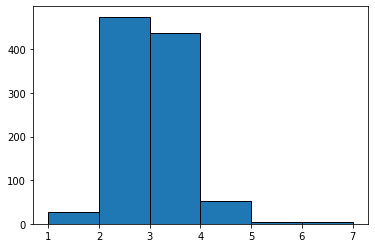

In [184]:
fig, ax = plt.subplots()
ax.hist(attempts_arr, ec='k', bins=range(1, 8))

In [183]:
np.mean(attempts_arr)

2.545

In [161]:
guess_scores=get_guess_scores(words_subset, possible_letters, required_letters)


In [162]:
%timeit guess_scores[guess_scores[:,1].astype(float).argsort()] # sort them so we can take a look

12.7 µs ± 361 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [163]:
%timeit np.argmin(guess_scores[:, 1].astype(float))

12 µs ± 971 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [134]:
# guess_scores=pickle.load(open("initial_guess_scores.pkl", "rb" )) # precomputed best guess 
# guess_scores = guess_scores[guess_scores[:,1].astype(float).argsort()]

In [248]:
# it works pretty well, and is definitely super human.
# it falls a little flat when looking attempting to determine the last few guesses as there isn't much
# differentiation and it is mostly down to luck.

# bug when choosing non suggested guess
# increase word libary to 2500
# profiling
# 